In [1]:
from imports import *

In [2]:
# Define names and filenames...

galaxy = 'ngc4254'
galaxy_hst = galaxy
root_dir = '/Users/abarnes/Dropbox/work/Smallprojects/galaxies'
rerun_masking = False

hstha_file = '%s/data_hstha/%s/hst_contsub/%s_hst_ha_sic.fits' %(root_dir, galaxy_hst, galaxy_hst)
muscat_file = '%s/data_hstha/%s/muse/%s_nebmask.fits' %(root_dir, galaxy_hst, galaxy.upper())
musha_file = '%s/data_hstha/%s/muse/%s-*_MAPS.fits' %(root_dir, galaxy_hst, galaxy.upper())
musha_file = glob(musha_file)[0] #because of resolution in name
cutout_dir = '%s/data_hstha_nebulae_catalogue/%s/cutouts' %(root_dir, galaxy_hst)
output_dir = '%s/data_hstha_nebulae_catalogue/%s/catalogue' %(root_dir, galaxy_hst)
cutouts_hdus_dir = '%s/data_hstha_nebulae_catalogue/%s/cutouts_hdus' %(root_dir, galaxy_hst)
regions_file = '%s/sample.reg' %cutout_dir
regions_pickel_file = '%s/sample.pickel' %cutout_dir
sample_table_file = '%s/data_misc/sample_table/phangs_sample_table_v1p6.fits' %root_dir
muscat_table_file = '%s/data_misc/Nebulae_catalogue_v3/Nebulae_catalogue_v3.fits' %root_dir

for prints in [hstha_file, muscat_file, musha_file, cutout_dir, output_dir, 
               cutouts_hdus_dir, regions_file, regions_pickel_file, 
               sample_table_file, muscat_table_file]:
    print(prints)

/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_hstha/ngc4254/hst_contsub/ngc4254_hst_ha_sic.fits
/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_hstha/ngc4254/muse/NGC4254_nebmask.fits
/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_hstha/ngc4254/muse/NGC4254-0.89asec_MAPS.fits
/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_hstha_nebulae_catalogue/ngc4254/cutouts
/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_hstha_nebulae_catalogue/ngc4254/catalogue
/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_hstha_nebulae_catalogue/ngc4254/cutouts_hdus
/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_hstha_nebulae_catalogue/ngc4254/cutouts/sample.reg
/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_hstha_nebulae_catalogue/ngc4254/cutouts/sample.pickel
/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_misc/sample_table/phangs_sample_table_v1p6.fits
/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_misc/Nebulae_catalogue_v

In [3]:
# Check if directories exist...
cat_misc.checkmakedir(output_dir)

# Loading files...
hstha_hdu = fits.open(hstha_file)[0]
muscat_hdu = fits.open(muscat_file)[0]

hstha_hdu = cat_misc.convert_to_float32(hstha_hdu)
muscat_hdu = cat_misc.convert_to_float32(muscat_hdu)

# Update arrays
muscat_hdu.data = np.array(muscat_hdu.data, dtype=float)
muscat_hdu.data[muscat_hdu.data==-1] = np.nan

# Interpolate masks
muscat_data_re, _ = reproject_interp(muscat_hdu, hstha_hdu.header)
muscat_data_mask = ~np.isnan(muscat_data_re)
data_outmask = hstha_hdu.data[~muscat_data_mask]

# Get RMS for whole map... 
std = stats.mad_std(data_outmask, ignore_nan=True)  # Get noise
std = stats.mad_std(data_outmask[data_outmask<20*std], ignore_nan=True)  
mean = np.nanmean(data_outmask[data_outmask<20*std])  
median = np.nanmedian(data_outmask[data_outmask<20*std])  
print(std, mean, median)

# Load regions, sample table and HDUs... 
hdus_cutouts = cat_misc.load_pickle('%s/hdus_all.pickel' %cutout_dir)
regions = cat_misc.load_pickle(regions_pickel_file)

sample_table = cat_misc.get_galaxyprops(galaxy, sample_table_file)
muscat_table = cat_misc.get_museprops(galaxy, muscat_table_file)

# Load cutout hdus with smoothed, masked, and non-masked data...
hdus_file = '%s/hdus_all_withmasked.pickel' %cutout_dir
muscat_regionIDs_file =  '%s/muscat_regionIDs.pickel' %cutout_dir

if os.path.exists(hdus_file) & ~rerun_masking:
    muscat_regionIDs = muscat_table['region_ID']
    hdus = cat_misc.load_pickle(hdus_file)
else: 
    muscat_regionIDs = muscat_table['region_ID']
    hdus = cat_mask.get_maskedhdus(hdus_cutouts, regions, muscat_regionIDs)
    cat_misc.save_pickle(hdus, hdus_file)

116.52447842590125 24.253899 21.304026
[INFO] [load_pickle] Load /Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_hstha_nebulae_catalogue/ngc4254/cutouts/hdus_all.pickel
[INFO] [load_pickle] Load /Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_hstha_nebulae_catalogue/ngc4254/cutouts/sample.pickel
[INFO] [get_galaxyprops] Getting sample table properties for ngc4254...
[INFO] [get_MuseProps] Getting MUSE catalouge properties for ngc4254...
[INFO] [load_pickle] Load /Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_hstha_nebulae_catalogue/ngc4254/cutouts/hdus_all_withmasked.pickel


In [4]:
props_all = []
hdus_mask = []
hdus_mask_id = []
hdus_data_masked = []

for i in tqdm(range(len(muscat_regionIDs)), desc='Get sources:', position=0):

    regionID = np.int16(muscat_regionIDs[i])
    # data = hdus['hstha_hdu_smooth_masked'][i].data.copy()
    # header = hdus['hstha_hdu_smooth_masked'][i].header.copy()
    data = hdus['hstha_hdu_masked'][i].data.copy()
    header = hdus['hstha_hdu_masked'][i].header.copy()

    mask_low = cat_mask.get_threshmask(data, std, median, thresh=2)
    mask_low_prune = cat_mask.get_prunemask(mask_low, thresh=50)
    mask_high = cat_mask.get_threshmask(data, std, median, thresh=4)
    mask_grow = ndimage.binary_dilation(mask_high, iterations=-1, mask=mask_low_prune)
    mask_prune = cat_mask.get_prunemask(mask_grow, thresh=9)
    # structure = cat_mask.get_circmask() 
    # mask_close = ndimage.binary_closing(mask_prune, iterations=2, structure=structure) # No longer do this...
    mask_close = mask_prune
    mask_final = mask_close.copy()

    hdu_mask = fits.PrimaryHDU(mask_final*1, header)
    hdus_mask += [hdu_mask]

    hdu_mask_id = hdu_mask.copy()
    hdu_mask_id.data = hdu_mask_id.data*i
    hdu_mask_id.data[~mask_final] = -1
    hdus_mask_id += [hdu_mask_id]

    data_masked = data.copy()
    data_masked[~mask_final] = np.nan
    hdu_data_masked = fits.PrimaryHDU(data_masked, header)
    hdus_data_masked += [hdu_data_masked]

    if np.nansum(~np.isnan(data_masked))==0:
        continue
    
    try:
        pixsize = np.array([np.abs(header['CDELT1']), np.abs(header['CDELT2'])]).mean() * au.degree
    except: 
        pixsize = np.array([np.abs(header['CD1_1']), np.abs(header['CD2_2'])]).mean() * au.degree

    if pixsize.value==1: 
        if 'CD1_1' in np.array(header.cards)[:,0]: 
            pixsize = np.array([np.abs(header['CD1_1']), np.abs(header['CD2_2'])]).mean() * au.degree
        elif 'PC1_1' in np.array(header.cards)[:,0]:
            pixsize = np.array([np.abs(header['PC1_1']), np.abs(header['PC2_2'])]).mean() * au.degree

    npix = np.nansum(mask_final) *au.pix
    flux = np.nansum(data_masked) *au.erg/au.s/au.cm**2
    flux_err = np.sqrt(npix)*std

    area_exact = npix.value*np.abs(pixsize.to(au.arcsec)**2)
    radius_circ = np.sqrt(area_exact/np.pi).to('arcsec')

    flux_max = np.nanmax(data_masked) *flux.unit
    flux_min = np.nanmin(data_masked) *flux.unit
    flux_mean = np.nanmean(data_masked) *flux.unit

    x_max, y_max = np.where(data_masked==flux_max.value.T)
    if len(x_max)>1 or len(y_max)>1:
        x_max, y_max = np.nanmean(x_max), np.nanmean(y_max)
    else: 
        x_max, y_max = x_max[0], y_max[0]

    data_zeros = data_masked.copy()
    data_zeros[np.isnan(data_zeros)] = 0
    x_com, y_com = ndimage.center_of_mass(data_zeros)

    wcs = WCS(header)
    ra_max, dec_max = wcs.array_index_to_world_values([[y_max, x_max]])[0] *au.deg
    ra_com, dec_com = wcs.array_index_to_world_values([[y_com, x_com]])[0] *au.deg

    table_data = [
                regionID, x_max, y_max, x_com, y_com, ra_max, dec_max, ra_com, dec_com,
                npix, flux, flux_err, area_exact, radius_circ, flux_max, flux_min, flux_mean,
                ]
    table_data = [np.array(table_data_) for table_data_ in table_data]

    table_names = [
                'region_ID', 'x_max', 'y_max', 'x_com', 'y_com', 'ra_max', 'dec_max', 'ra_com', 'dec_com',
                'npix', 'flux', 'flux_err', 'area_exact', 'radius_circ', 'flux_max', 'flux_min', 'flux_mean',
                ]

    # Create table...
    props = QTable(data=np.array(table_data), names=table_names)
    props['x_max'].unit = au.pix
    props['y_max'].unit = au.pix
    props['x_com'].unit = au.pix
    props['y_com'].unit = au.pix
    props['ra_max'].unit = ra_max.unit
    props['dec_max'].unit = dec_max.unit
    props['ra_com'].unit = ra_com.unit
    props['dec_com'].unit = ra_max.unit
    props['npix'].unit = au.pix
    props['flux'].unit = flux.unit
    props['flux_err'].unit = flux.unit
    props['area_exact'].unit = area_exact.unit
    props['radius_circ'].unit = radius_circ.unit
    props['flux_max'].unit = flux_max.unit
    props['flux_min'].unit = flux_min.unit
    props['flux_mean'].unit = flux_mean.unit

    pcperarcsec = cat_props.get_pcperarcsec(sample_table)
    props['radius_circ_pc'] = props['radius_circ']*pcperarcsec

    props_all += [props]

    data_masked_zero = data_masked.copy()
    data_masked_zero[np.isnan(data_masked_zero)] = 0
    
    # Get dendro properties...
    dendro = Dendrogram.compute(data_masked, min_delta=-1000, min_value=0, min_npix=0, wcs=wcs)

    metadata = {}
    metadata['data_unit'] = au.Jy / au.beam  # Dummy unit
    metadata['spatial_scale'] = pixsize.to('arcsec')
    metadata['beam_major'] = 0.1 * au.arcsec
    metadata['beam_minor'] = metadata['beam_major']

    props_dendro = pp_catalog(dendro.trunk, metadata, verbose=False)  
    props_dendro = QTable(props_dendro)
    props_dendro = props_dendro[np.nanargmax(props_dendro['flux'])]

    ra_dendro, dec_dendro = wcs.array_index_to_world_values([[props_dendro['x_cen'].value, props_dendro['y_cen'].value]])[0] *au.deg

    # Add dendro properties to table...
    props['x_mom'] = props_dendro['x_cen']
    props['y_mom'] = props_dendro['y_cen']
    props['ra_mom'] = ra_dendro
    props['dec_mom'] = dec_dendro
    props['area_ellipse'] = props_dendro['area_ellipse']
    props['major_sigma'] = props_dendro['major_sigma']
    props['minor_sigma'] = props_dendro['minor_sigma']
    props['mean_sigma'] = props_dendro['radius']
    props['position_angle'] = props_dendro['position_angle']
    props['area_ellipse'] = props_dendro['area_ellipse']
    props['mean_sigma_pc'] = props['mean_sigma']*pcperarcsec

    # Get dendro complexity... 
    dendro = Dendrogram.compute(data_masked, min_delta=(std*5), min_value=(std*3)+median, min_npix=20, wcs=wcs)
    dendro_IDs = np.unique(dendro.index_map.data)
    dendro_IDs = [dendro_ID for dendro_ID in dendro_IDs if dendro_ID > -1]
    dendro_complex = len(dendro_IDs)
    props['complexity_score'] = dendro_complex

    # Get flags...
    # Edge  
    flag_edge = np.isnan(hdus['hstha_hdu_masked_ones'][i].data).any()*1
    props.add_column(Column(flag_edge, name='flag_edge_hst')) 
    # Touch
    mask_touch = (ndimage.binary_dilation(mask_final) & ~mask_final)
    flag_touch = (np.nansum(np.isnan(data[mask_touch])) > 0)*1
    props.add_column(Column(flag_touch, name='flag_touch_hst')) 

# Stack all properties...
props_all = vstack(props_all)

# Add additional infomation from MUSE and save... 
muscat_table = cat_misc.get_museprops(galaxy, muscat_table_file)
muscat_table_rename = muscat_table.copy()
columns = muscat_table_rename.colnames
for column in columns:
    muscat_table_rename.rename_column(column, column+'_MUSE')
muscat_table_rename.rename_column('gal_name_MUSE', 'gal_name')
muscat_table_rename.rename_column('region_ID_MUSE', 'region_ID')
muscat_table_rename.rename_column('Lum_HA6562_CORR_MUSE', 'HA6562_LUMINOSITY_MUSE')

# Concatenate tables...
props_all_final = join(props_all, muscat_table_rename, keys='region_ID')

# Correct fluxes and luminosities...
props_all_final['flux_corr'] = cat_props.correct_ha_flux(props_all_final, props_all_final['flux'])
props_all_final['flux_err_corr'] = cat_props.correct_ha_flux(props_all_final, props_all_final['flux_err'])
props_all_final['lum_hst'] = cat_props.calculate_luminosity(props_all_final['flux_corr']*1e-20, sample_table['dist'].quantity[0])   
props_all_final['lum_err_hst'] = cat_props.calculate_luminosity(props_all_final['flux_err_corr']*1e-20, sample_table['dist'].quantity[0])   

# Add additional properties...
props_all_final['region_circ_rad_pc_MUSE'] = cat_props.calculate_radius(props_all_final['region_circ_rad_MUSE'], sample_table['dist'].quantity[0])  

# Rename columns...
props_all_final.rename_column('flux', 'HA6562_FLUX_HST')
props_all_final.rename_column('flux_err', 'HA6562_FLUX_ERR_HST')
props_all_final.rename_column('flux_corr', 'HA6562_FLUX_CORR_HST')
props_all_final.rename_column('flux_err_corr', 'HA6562_FLUX_ERR_CORR_HST')
props_all_final.rename_column('lum_hst', 'HA6562_LUMINOSITY_HST')
props_all_final.rename_column('lum_err_hst', 'HA6562_LUMINOSITY_ERR_HST')

# Save...
props_all_final.write('%s/props_all.fits' %output_dir, overwrite=True)

# Save masks...
cat_mask.get_hdumask(hstha_hdu, hdus_mask_id, outputfile='%s/%s_mask.fits' %(output_dir, galaxy))
cat_mask.get_hducomplex(props_all_final, inputfile='%s/%s_mask.fits' %(output_dir, galaxy), outputfile='%s/%s_complexity.fits' %(output_dir, galaxy))
cat_mask.get_ds9regions(props_all, outputfile='%s/%s_mask' %(output_dir, galaxy))

Get sources:: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 2960/2960 [00:38<00:00, 77.18it/s]


[INFO] [get_MuseProps] Getting MUSE catalouge properties for ngc4254...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 909/909 [00:34<00:00, 26.23it/s]


In [5]:
props_all_final

region_ID,x_max,y_max,x_com,y_com,ra_max,dec_max,ra_com,dec_com,npix,HA6562_FLUX_HST,HA6562_FLUX_ERR_HST,area_exact,radius_circ,flux_max,flux_min,flux_mean,radius_circ_pc,x_mom,y_mom,ra_mom,dec_mom,area_ellipse,major_sigma,minor_sigma,mean_sigma,position_angle,mean_sigma_pc,complexity_score,flag_edge_hst,flag_touch_hst,gal_name,cen_x_MUSE,cen_y_MUSE,cen_ra_MUSE,cen_dec_MUSE,cen_x_geo_MUSE,cen_y_geo_MUSE,flag_edge_MUSE,flag_nearby_MUSE,flag_star_MUSE,deproj_dist_MUSE,deproj_phi_MUSE,region_area_MUSE,region_circ_rad_MUSE,HB4861_FLUX_MUSE,OIII5006_FLUX_MUSE,HA6562_FLUX_MUSE,NII6583_FLUX_MUSE,SII6716_FLUX_MUSE,SII6730_FLUX_MUSE,SIII9068_FLUX_MUSE,OI6300_FLUX_MUSE,NII5754_FLUX_MUSE,HEI5875_FLUX_MUSE,SIII6312_FLUX_MUSE,OI6363_FLUX_MUSE,OII7319_FLUX_MUSE,OII7330_FLUX_MUSE,HB4861_FLUX_ERR_MUSE,OIII5006_FLUX_ERR_MUSE,HA6562_FLUX_ERR_MUSE,NII6583_FLUX_ERR_MUSE,SII6716_FLUX_ERR_MUSE,SII6730_FLUX_ERR_MUSE,SIII9068_FLUX_ERR_MUSE,OI6300_FLUX_ERR_MUSE,NII5754_FLUX_ERR_MUSE,HEI5875_FLUX_ERR_MUSE,SIII6312_FLUX_ERR_MUSE,OI6363_FLUX_ERR_MUSE,OII7319_FLUX_ERR_MUSE,OII7330_FLUX_ERR_MUSE,HA6562_SIGMA_MUSE,NII6583_SIGMA_MUSE,OIII5006_SIGMA_MUSE,HA6562_VEL_MUSE,NII6583_VEL_MUSE,OIII5006_VEL_MUSE,HA6562_SIGMA_ERR_MUSE,NII6583_SIGMA_ERR_MUSE,OIII5006_SIGMA_ERR_MUSE,HA6562_VEL_ERR_MUSE,NII6583_VEL_ERR_MUSE,OIII5006_VEL_ERR_MUSE,HB4861_FLUX_CORR_MUSE,OIII5006_FLUX_CORR_MUSE,HA6562_FLUX_CORR_MUSE,NII6583_FLUX_CORR_MUSE,SII6716_FLUX_CORR_MUSE,SII6730_FLUX_CORR_MUSE,SIII9068_FLUX_CORR_MUSE,OI6300_FLUX_CORR_MUSE,NII5754_FLUX_CORR_MUSE,HEI5875_FLUX_CORR_MUSE,SIII6312_FLUX_CORR_MUSE,OI6363_FLUX_CORR_MUSE,OII7319_FLUX_CORR_MUSE,OII7330_FLUX_CORR_MUSE,HB4861_FLUX_CORR_ERR_MUSE,OIII5006_FLUX_CORR_ERR_MUSE,HA6562_FLUX_CORR_ERR_MUSE,NII6583_FLUX_CORR_ERR_MUSE,SII6716_FLUX_CORR_ERR_MUSE,SII6730_FLUX_CORR_ERR_MUSE,SIII9068_FLUX_CORR_ERR_MUSE,OI6300_FLUX_CORR_ERR_MUSE,NII5754_FLUX_CORR_ERR_MUSE,HEI5875_FLUX_CORR_ERR_MUSE,SIII6312_FLUX_CORR_ERR_MUSE,OI6363_FLUX_CORR_ERR_MUSE,OII7319_FLUX_CORR_ERR_MUSE,OII7330_FLUX_CORR_ERR_MUSE,EBV_MUSE,EBV_ERR_MUSE,met_scal_MUSE,met_scal_err_MUSE,logq_D91_MUSE,logq_D91_err_MUSE,t_N2_MUSE,t_S3_MUSE,t_N2_err_MUSE,t_S3_err_MUSE,BPT_NII_MUSE,BPT_SII_MUSE,BPT_OI_MUSE,LOG_SIGMA_SFR_CHAB_MUSE,LOG_SIGMA_STMASS_CHAB_MUSE,5thNN_dist_MUSE,NN_number_MUSE,Environment_MUSE,r_R25_MUSE,r_reff_MUSE,HA6562_LUMINOSITY_MUSE,Delta_met_scal_MUSE,pc_per_pixel_MUSE,EW_HA6562_raw_MUSE,EW_HA6562_raw_ERR_MUSE,EW_HB4861_raw_MUSE,EW_HB4861_raw_ERR_MUSE,EW_HA6562_fit_MUSE,EW_HA6562_fit_ERR_MUSE,EW_HB4861_fit_MUSE,EW_HB4861_fit_ERR_MUSE,EW_HA6562_bgcorr_MUSE,EW_HA6562_bgcorr_ERR_MUSE,EW_HB4861_bgcorr_MUSE,EW_HB4861_bgcorr_ERR_MUSE,HII_class_v2_MUSE,HII_class_v3_MUSE,HA6562_FLUX_CORR_HST,HA6562_FLUX_ERR_CORR_HST,HA6562_LUMINOSITY_HST,HA6562_LUMINOSITY_ERR_HST,region_circ_rad_pc_MUSE
,pix,pix,pix,pix,deg,deg,deg,deg,pix,erg / (s cm2),erg / (s cm2),arcsec2,arcsec,erg / (s cm2),erg / (s cm2),erg / (s cm2),pc,pix,pix,deg,deg,arcsec2,arcsec,arcsec,arcsec,deg,pc,,,,,pix,pix,deg,deg,pix,pix,,,,arcsec,rad,pix2,arcsec,1e-20 erg / (s cm2),1e-20 erg / (s cm2),1e-20 erg / (s cm2),1e-20 erg / (s cm2),1e-20 erg / (s cm2),1e-20 erg / (s cm2),1e-20 erg / (s cm2),1e-20 erg / (s cm2),1e-20 erg / (s cm2),1e-20 erg / (s cm2),1e-20 erg / (s cm2),1e-20 erg / (s cm2),1e-20 erg / (s cm2),1e-20 erg / (s cm2),1e-20 erg / (s cm2),1e-20 erg / (s cm2),1e-20 erg / (s cm2),1e-20 erg / (s cm2),1e-20 erg / (s cm2),1e-20 erg / (s cm2),1e-20 erg / (s cm2),1e-20 erg / (s cm2),1e-20 erg / (s cm2),1e-20 erg / (s cm2),1e-20 erg / (s cm2),1e-20 erg / (s cm2),1e-20 erg / (s cm2),1e-20 erg / (s cm2),km / s,km / s,km / s,km / s,km / s,km / s,km / s,km / s,km / s,km / s,km / s,km / s,erg / (s cm2),erg / (s cm2),erg / (s cm2),erg / (s cm2),erg / (s cm2),erg / (s cm2),erg / (s cm2),erg / (s cm2),erg / (s cm2),erg / (s cm2),erg / (s cm2),erg / (s cm2),erg / (s cm2),erg / (s cm2),erg / (s cm2),erg / (s cm2),erg / (s cm2),erg / (s cm2),erg / (s cm2),erg / (s cm2),erg / (s cm2),erg / (s cm2),erg / (s cm2),erg / (s 

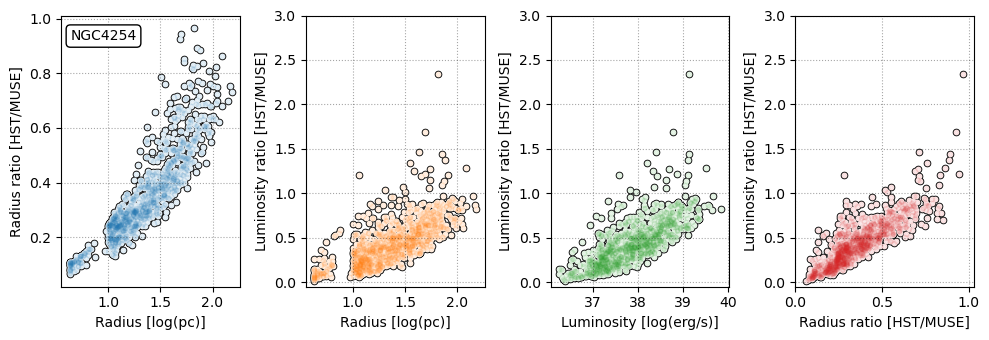

In [6]:
import matplotlib.pyplot as plt

table = props_all_final
gal_names = np.unique(table['gal_name'])

for i, gal_name in enumerate(gal_names):
    
    mask = table['gal_name'] == gal_name

    data_x1 = table['radius_circ_pc'].value[mask]
    data_y1 = table['HA6562_LUMINOSITY_HST'].value[mask]
    data_x1_log = np.log10(data_x1.copy())
    data_y1_log = np.log10(data_y1.copy())

    data_x2 = table['region_circ_rad_pc_MUSE'].value[mask]
    data_y2 = table['HA6562_LUMINOSITY_MUSE'].value[mask]

    data_x = data_x1/data_x2
    data_y = data_y1/data_y2

    fig = plt.figure(figsize=(10, 3.5)) 
    ax1 = fig.add_subplot(141)
    ax2 = fig.add_subplot(142)
    ax3 = fig.add_subplot(143)
    ax4 = fig.add_subplot(144)

    ax1.scatter(data_x1_log, data_x, s=20, c='black', rasterized=True)
    ax1.scatter(data_x1_log, data_x, s=10, c='white', rasterized=True)
    ax1.scatter(data_x1_log, data_x, s=10, alpha=0.1, c='C0')

    ax2.scatter(data_x1_log, data_y, s=20, c='black', rasterized=True)
    ax2.scatter(data_x1_log, data_y, s=10, c='white', rasterized=True)
    ax2.scatter(data_x1_log, data_y, s=10, alpha=0.1, c='C1')

    ax3.scatter(data_y1_log, data_y, s=20, c='black', rasterized=True)
    ax3.scatter(data_y1_log, data_y, s=10, c='white', rasterized=True)
    ax3.scatter(data_y1_log, data_y, s=10, alpha=0.1, c='C2')

    ax4.scatter(data_x, data_y, s=20, c='black', rasterized=True)
    ax4.scatter(data_x, data_y, s=10, c='white', rasterized=True)
    ax4.scatter(data_x, data_y, s=10, alpha=0.1, c='C3')

    ax1.grid(True, alpha=0.35, ls=':', color='black')
    ax2.grid(True, alpha=0.35, ls=':', color='black')
    ax3.grid(True, alpha=0.35, ls=':', color='black')
    ax4.grid(True, alpha=0.35, ls=':', color='black')

    ax1.set_xlabel('Radius [log(pc)]')
    ax2.set_xlabel('Radius [log(pc)]')
    ax1.set_ylabel('Radius ratio [HST/MUSE]')
    ax3.set_xlabel('Luminosity [log(erg/s)]')
    ax4.set_xlabel('Radius ratio [HST/MUSE]')
    ax2.set_ylabel('Luminosity ratio [HST/MUSE]')
    ax3.set_ylabel('Luminosity ratio [HST/MUSE]')
    ax4.set_ylabel('Luminosity ratio [HST/MUSE]')

    ax1.text(0.05, 0.95, gal_name, ha='left', va='top', bbox=dict(facecolor='white', boxstyle='round', alpha=1), transform=ax1.transAxes, color='k')

    ax2.set_ylim(-0.05, 3)
    ax3.set_ylim(-0.05, 3)
    ax4.set_ylim(-0.05, 3)
    ax4.set_xlim(0, 1.03)

    fig.tight_layout(h_pad=0.5, w_pad=0.5)

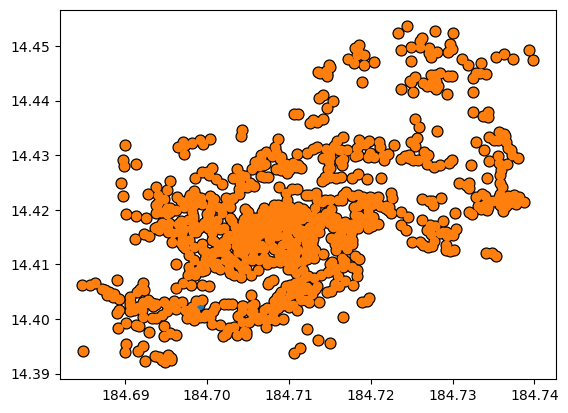

In [7]:
data_x1 = table['radius_circ_pc'].value
data_y1 = table['HA6562_LUMINOSITY_HST'].value

data_x2 = table['region_circ_rad_pc_MUSE'].value
data_y2 = table['HA6562_LUMINOSITY_MUSE'].value

data_x = data_x1/data_x2
data_y = data_y1/data_y2

mask = data_y>1.5
plt.scatter(props_all_final['ra_max'], props_all_final['dec_max'], c='k', s=60)
plt.scatter(props_all_final['ra_max'][mask], props_all_final['dec_max'][mask])
plt.scatter(props_all_final['ra_max'][~mask], props_all_final['dec_max'][~mask])